# Preprocessing and clustering

## 1. Setup and read in data

In [1]:
from pathlib import Path

import janitor
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.2 scipy==1.7.2 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.0 python-igraph==0.9.8 pynndescent==0.5.5


Path and file locations

In [3]:
HOME = Path("/Users/omorris/Documents/projects/ovarian_cancer/scRNAseq/e-mtab-8559/")
INPUTS = HOME / "inputs"
OUTPUTS = HOME / "outputs"

results_file = "test.h5ad"

In [4]:
adata = sc.read_h5ad(INPUTS / "data/E-MTAB-8559/E-MTAB-8559.h5ad")

## 2. Preprocessing

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

Correct problem with ensembl gene ids

In [6]:
adata.var_names

Index(['ENSG00000000003', 'ENSG00000000419', 'ENSG00000000457',
       'ENSG00000000460', 'ENSG00000000938', 'ENSG00000000971',
       'ENSG00000001036', 'ENSG00000001084', 'ENSG00000001167',
       'ENSG00000001460',
       ...
       'ENSG00000288380', 'ENSG00000288393', 'ENSG00000288436',
       'ENSG00000288520', 'ENSG00000288529', 'ENSG00000288534',
       'ENSG00000288547', 'ENSG00000288550', 'ENSG00000288558',
       'ENSG00000288564'],
      dtype='object', length=21725)

In [7]:
hgnc = pd.read_csv(
    "/Users/omorris/Documents/useful_data/hgnc_complete_set.txt",
    low_memory=False,
    index_col=0,
)

In [8]:
names = pd.merge(
    adata.var_names.to_frame(name="test"),
    hgnc.set_index("ensembl_gene_id"),
    how="left",
    left_index=True,
    right_index=True,
)[["test", "symbol"]]

names.loc[names.symbol.isna(), "symbol"] = names.loc[names.symbol.isna(), "test"]

adata.var_names = names.symbol
adata.var_names

Index(['TSPAN6', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2', 'GCLC',
       'NFYA', 'STPG1',
       ...
       'ENSG00000288380', 'ZNF75CP', 'ENSG00000288436', 'ENSG00000288520',
       'ENSG00000288529', 'ENSG00000288534', 'C3orf36', 'ENSG00000288550',
       'DUS4L-BCAP29', 'ENSG00000288564'],
      dtype='object', name='symbol', length=21725)

The highest expressed genes are currently mostly mitochondrial and ribosomal. This is as it should be. Concern would be if high number of pseudogenes, which might suggest problems with alignment. 

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20)

normalizing counts per cell
    finished (0:00:00)


In [10]:
adata.var["mt"] = adata.var_names.str.startswith(
    "MT-"
)  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

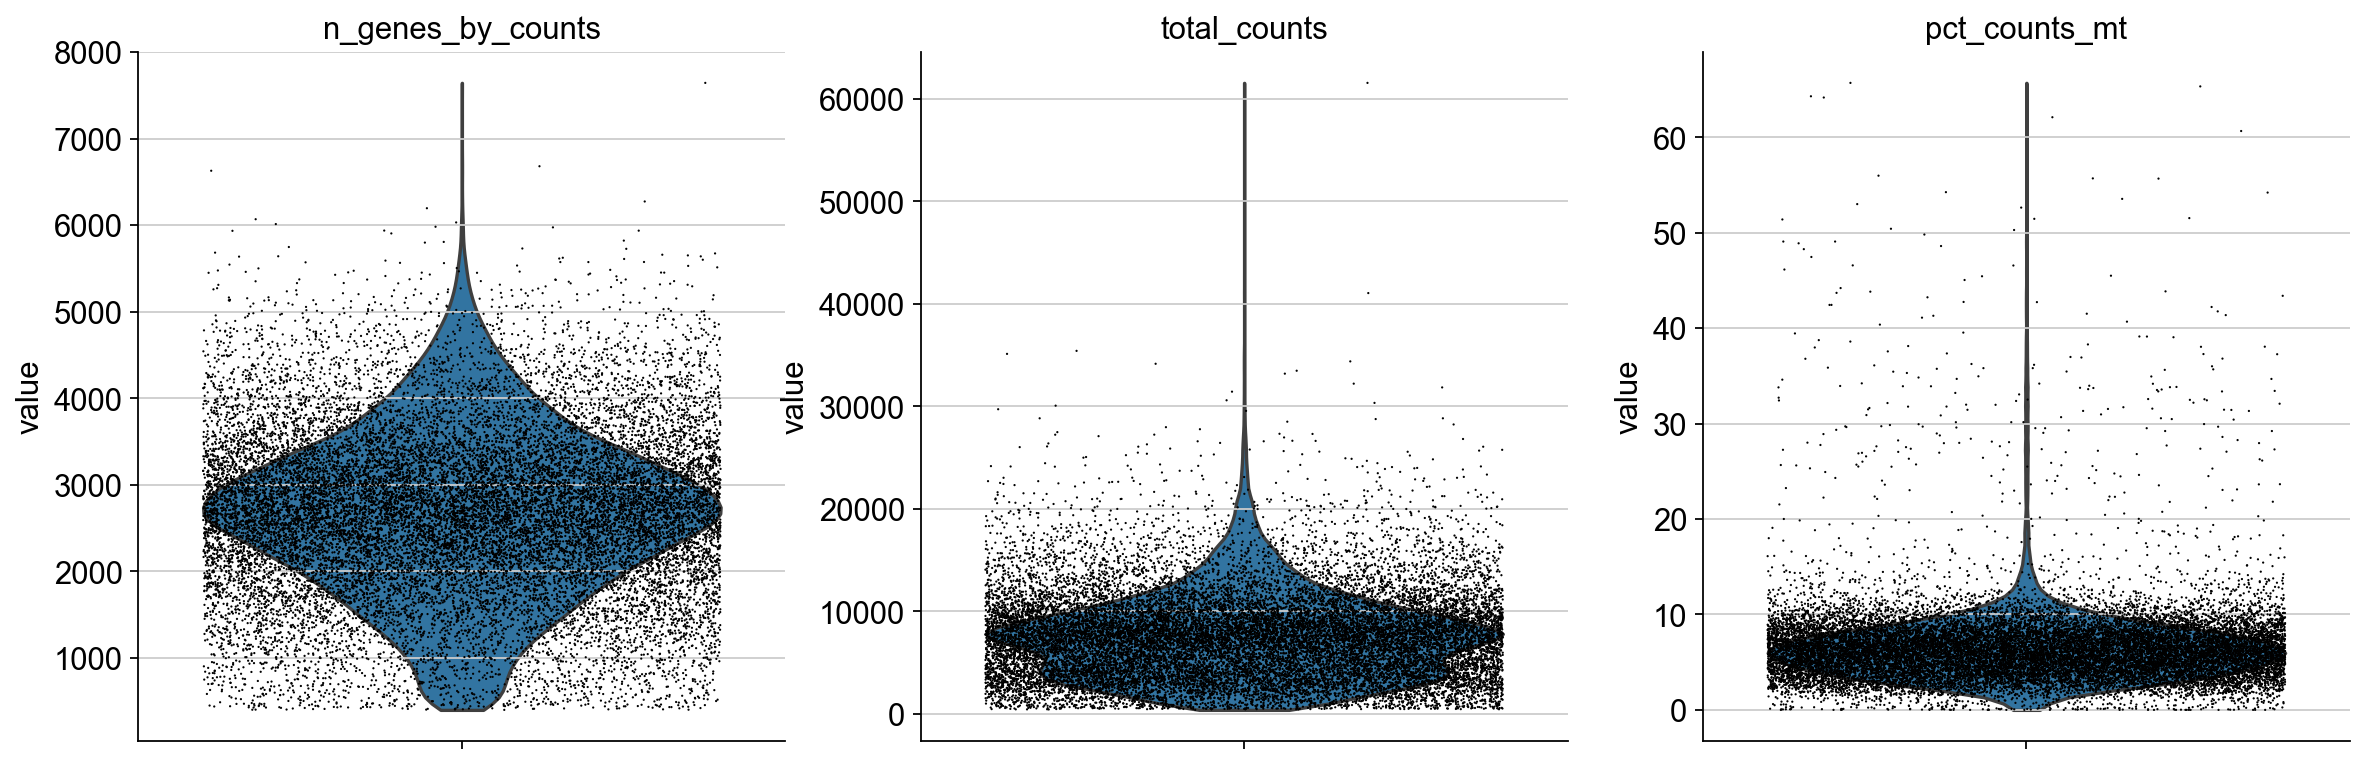

In [11]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

High mitochondrial reads. Will try filtering these out.

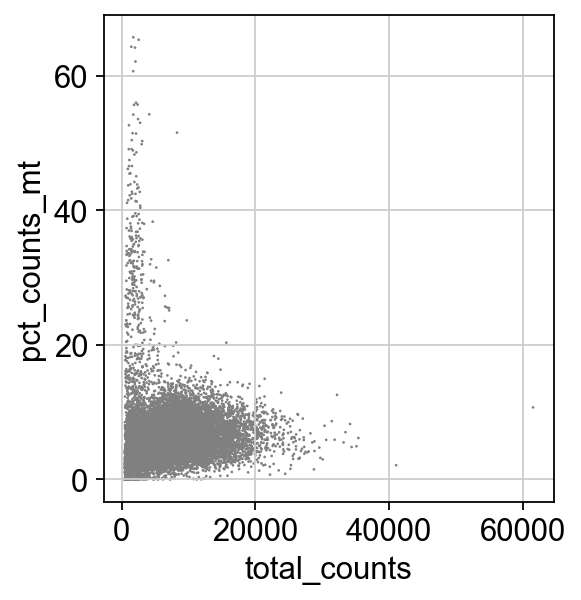

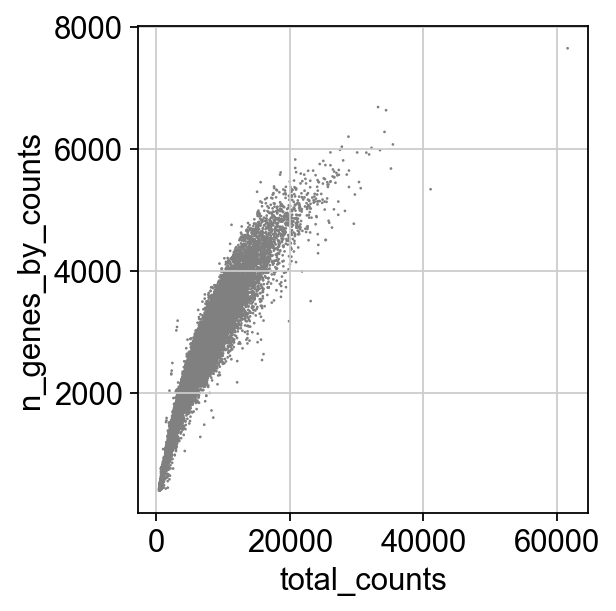

In [12]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [13]:
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.pct_counts_mt < 18, :]

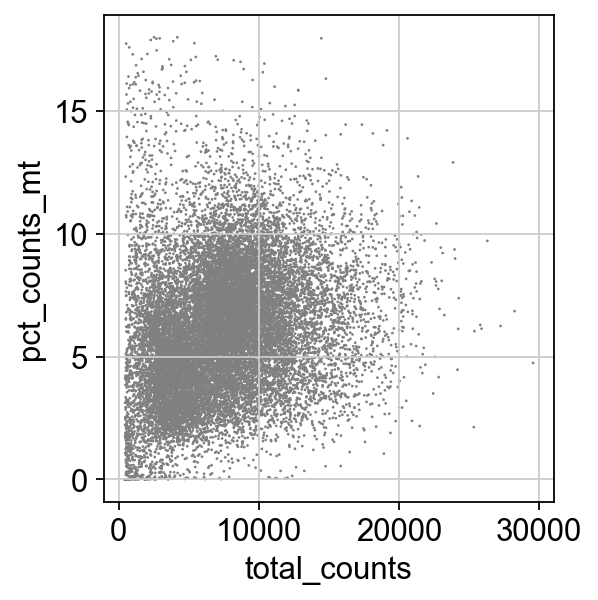

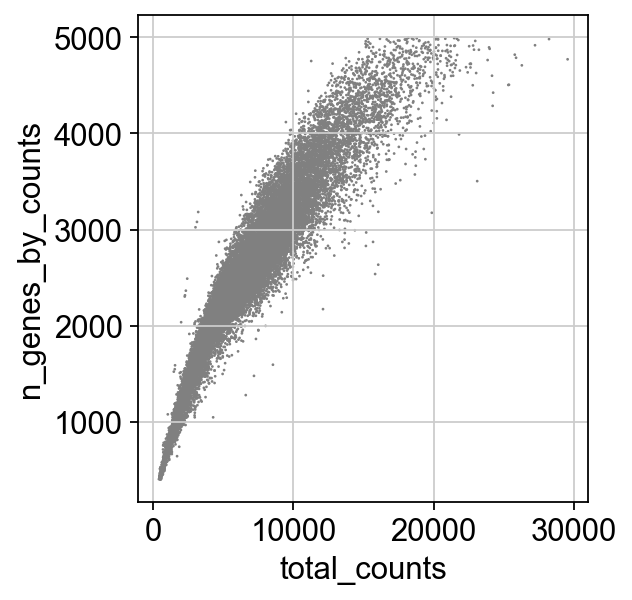

In [14]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [15]:
sc.pp.normalize_total(adata, exclude_highly_expressed=True)

/Users/omorris/miniconda3/envs/scpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['FTL', 'TIMP1', 'RPS19', 'FN1', 'MT2A', 'FTH1', 'MT-CO2', 'MTRNR2L12']
    finished (0:00:00)


In [16]:
sc.pp.log1p(adata)

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


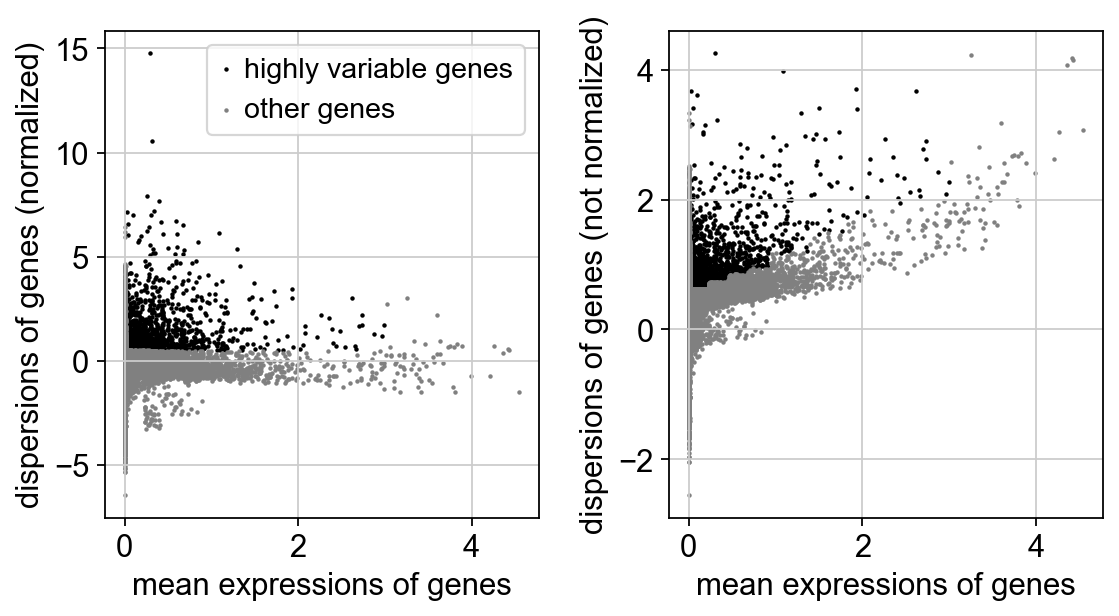

In [16]:
sc.pl.highly_variable_genes(adata)

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This freezes the state of the AnnData object.

## 3. Analysing highly variable genes

In [27]:
adata = adata[:, adata.var.highly_variable]

In [28]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:41)


In [29]:
sc.pp.scale(adata, max_value=10)

In [35]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)


In [43]:
sc.pl.pca(adata, color="TP53")

In [37]:
sc.pl.pca_variance_ratio(adata, log=True)

In [38]:
results_file

'test.h5ad'

In [39]:
adata.write(OUTPUTS / results_file)

## Plotting UMAP

In [59]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [60]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


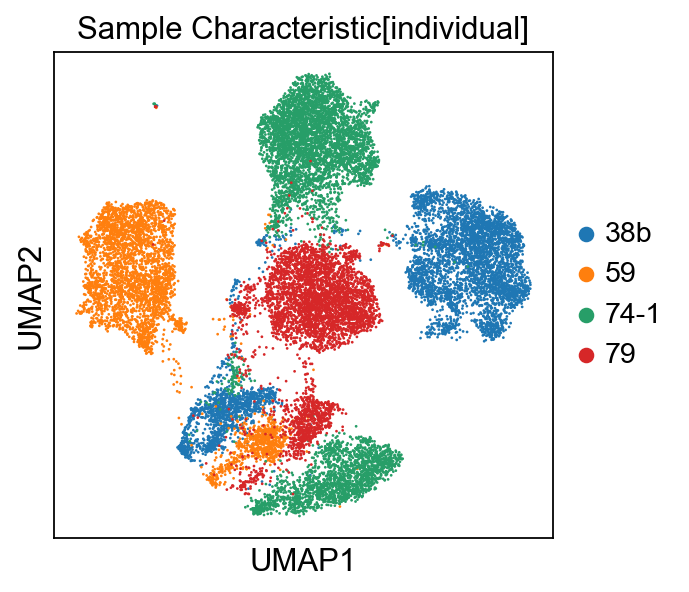

In [55]:
sc.pl.umap(adata, color=["Sample Characteristic[individual]"])

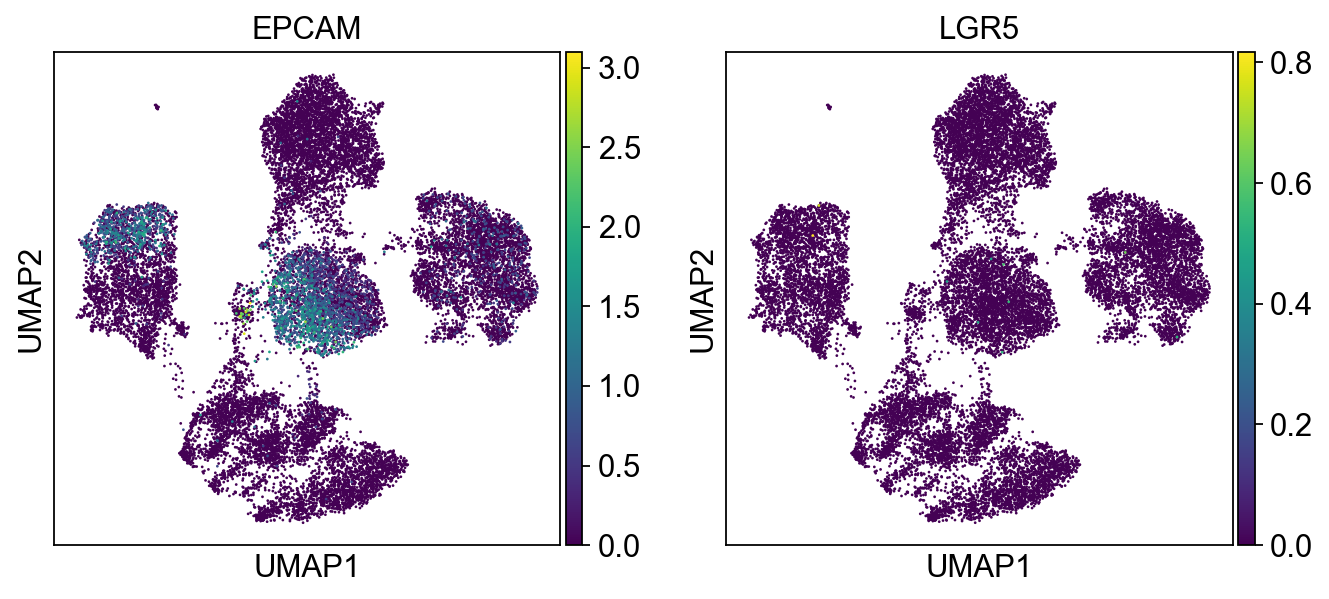

In [62]:
sc.pl.umap(adata, color=["EPCAM", "LGR5"])